## Time series of glacial and continental river contributions across boundaries

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
from matplotlib.ticker import FormatStrFormatter
import warnings
import os 
from datetime import date
warnings.filterwarnings('ignore')

%matplotlib inline

##### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

# Time series folders:
folder_ref   = '/ocean/brogalla/GEOTRACES/time-series/Mn-set4-202004/'
folder_riv2a = '/ocean/brogalla/GEOTRACES/time-series/riv-2a-202005/'
folder_riv2b = '/ocean/brogalla/GEOTRACES/time-series/riv-2b-202005/'
folder_nosed = '/ocean/brogalla/GEOTRACES/time-series/nosed-202005/'

# Set boundary coordinates:
l1i = 2013-imin;                      l1j = np.arange(300-jmin,392-jmin)
l2i = 1935-imin;                      l2j = np.arange(450-jmin,530-jmin)
l3i = np.arange(1850-imin,1885-imin); l3j = 555-jmin
l4i = np.arange(1753-imin,1837-imin); l4j = 568-jmin
l5i = np.arange(1720-imin,1790-imin); l5j = 605-jmin
l6i = 1730-imin;                      l6j = np.arange(660-jmin,690-jmin)
t1i = np.arange(1635-imin,1653-imin); t1j = 760-jmin
r1i = 1520-imin;                      r1j = np.arange(505-jmin,673-jmin)
r2i = 1520-imin;                      r2j = np.arange(385-jmin,405-jmin)
N1i = np.arange(1570-imin,1630-imin); N1j = 635-jmin #Nares
P1i = 1585-imin;                      P1j = np.arange(485-jmin,538-jmin)  #Parry channel

# Colours for the boundaries:
bdy_colours  = ['#386c82','#6e8bce','#992622','#36ab92','#085965','#ce9169']

##### Load files:

In [3]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:])

mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
lons  = np.array(mesh.variables['nav_lon'])
lats  = np.array(mesh.variables['nav_lat'])
tmask = tmask[0,:,imin:imax,jmin:jmax]

In [4]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set4-202004/ref-2003/ANHA12_EXH006_2003_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

##### Functions:

In [5]:
def time_series_pickle(year, riv_2a=False, riv_2b=False, nosed=False):
    
    # Load calculated time series of fluxes:
    if riv_2a:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 =  \
                                pickle.load(open(folder_riv2a+'time-series-'+str(year)+'.pickle','rb'))  
    elif riv_2b:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 =  \
                                pickle.load(open(folder_riv2b+'time-series-'+str(year)+'.pickle','rb'))  
    elif nosed:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 =  \
                                pickle.load(open(folder_nosed+'time-series-'+str(year)+'.pickle','rb'))  
    else:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 =  \
                                pickle.load(open(folder_ref+'time-series-'+str(year)+'.pickle','rb'))
    
    # Conservation of volume check:
    sum_V = -1*np.sum(time_series_V1,axis=2) - np.sum(time_series_V2,axis=2) - np.sum(time_series_V7,axis=2) - \
           (np.sum(time_series_V3,axis=2) + np.sum(time_series_V4,axis=2) + np.sum(time_series_V5,axis=2) + \
            np.sum(time_series_V6,axis=2)) + np.sum(time_series_V8,axis=2) + np.sum(time_series_V9,axis=2)
#     print('Total volume change at end of time period: ', np.sum(sum_V))
    
    # Combine western CAA time series:
    time_series_mn_WCAA = np.sum(np.sum(time_series_mn3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn6,axis=2),axis=1)
    time_series_V_WCAA = np.sum(np.sum(time_series_V3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V6,axis=2),axis=1)
    
    return time_series_mn1, time_series_mn2, time_series_mn_WCAA, time_series_mn7, time_series_mn8, \
            time_series_mn9, time_series_mn10, time_series_mn11

In [6]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1 = np.sort(os.listdir('/data/brogalla/run_storage/Mn-set4-202004/ref-'+str(year)+'/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

In [7]:
def calculate_fluxes(year):
    ts_ref1, ts_ref2, ts_ref_WCAA, ts_ref7, ts_ref8, ts_ref9, ts_ref10, ts_ref11 = time_series_pickle(year)
    ts_2a1, ts_2a2, ts_2a_WCAA, ts_2a7, ts_2a8, ts_2a9, ts_2a10, ts_2a11 = time_series_pickle(year, riv_2a=True)
    ts_2b1, ts_2b2, ts_2b_WCAA, ts_2b7, ts_2b8, ts_2b9, ts_2b10, ts_2b11 = time_series_pickle(year, riv_2b=True)
    ts_nosed1, ts_nosed2, ts_nosed_WCAA, ts_nosed7, ts_nosed8, \
                                       ts_nosed9, ts_nosed10, ts_nosed11 = time_series_pickle(year, nosed=True)
    
    Nout_ref   = np.sum(-1*ts_ref10, axis=(1,2))
    Nout_riv   = np.sum(-1*ts_2a10, axis=(1,2))
    Nout_con   = np.sum(-1*ts_2b10, axis=(1,2))
    Nout_nosed = np.sum(-1*ts_nosed10, axis=(1,2))
    
    Nin_ref    = np.sum(-1*ts_ref7, axis=(1,2))
    Nin_riv    = np.sum(-1*ts_2a7, axis=(1,2))
    Nin_con    = np.sum(-1*ts_2b7, axis=(1,2))
    Nin_nosed  = np.sum(-1*ts_nosed7, axis=(1,2))
    
    return Nout_ref, Nout_riv, Nout_con, Nout_nosed

##### Figures:

Time series across boundaries
- Positive --- into domain
- Negative --- out of domain

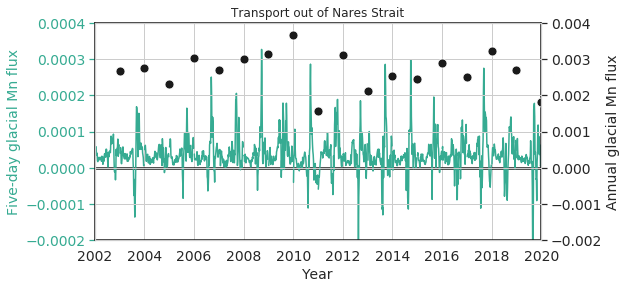

In [67]:
st = sns.axes_style("whitegrid")
    
with st:
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    
    sns.lineplot([dt.datetime(2002,1,1), dt.datetime(2020,1,1)], [0,0], linewidth=2.5, color='k', ax=ax)
    
    # Flux at the end of the previous year:
    prev_year_ref = 0; prev_year_riv = 0; prev_year_con = 0; 
    sum_Nout=[]    
    for year in range(2002, 2019+1):
        # Calculate volume and Mn fluxes
        Nout_ref, Nout_riv, Nout_con, Nout_nosed = calculate_fluxes(year)
            
        dates_year    = file_dates(year)    
            
        # Plot lines:
        sns.lineplot(dates_year, (Nout_riv-Nout_ref)  , linewidth=1.5, color=bdy_colours[3], ax=ax)
    
        sum_Nout.append(np.sum(Nout_riv-Nout_ref))
        
    ax2 = ax.twinx()
    sns.scatterplot([dt.datetime(year,12,31) for year in range(2002,2020)], sum_Nout, color='k', s=80, ax=ax2)
    
    # Figure settings:
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.0002, 0.0004))
    ax2.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.002, 0.004))
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Five-day glacial Mn flux', fontsize=14, color=bdy_colours[3])
    ax2.set_ylabel('Annual glacial Mn flux', fontsize=14)
    ax.tick_params(axis='y', colors=bdy_colours[3])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title('Transport out of Nares Strait')
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

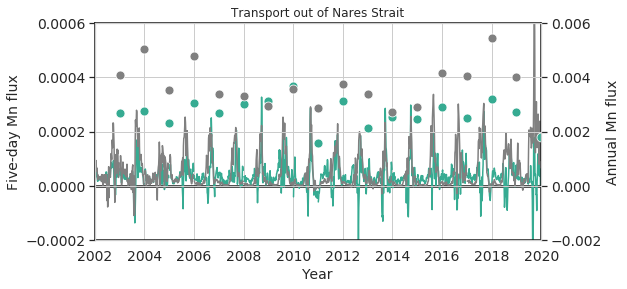

In [77]:
st = sns.axes_style("whitegrid")
    
with st:
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax2 = ax.twinx()
    
    sns.lineplot([dt.datetime(2002,1,1), dt.datetime(2020,1,1)], [0,0], linewidth=2.5, color='k', ax=ax)
    
    # Flux at the end of the previous year:
    prev_year_ref = 0; prev_year_riv = 0; prev_year_con = 0; 
    sum_Nout_glac = []; sum_Nout_ice = [];    
    for year in range(2002, 2019+1):
        # Calculate volume and Mn fluxes
        Nout_ref, Nout_riv, Nout_con, Nout_nosed = calculate_fluxes(year)
            
        dates_year    = file_dates(year)    
            
        # Plot lines:
        sns.lineplot(dates_year, (Nout_riv-Nout_ref)  , linewidth=1.5, color=bdy_colours[3], ax=ax)
        sns.lineplot(dates_year, (Nout_ref-Nout_nosed), linewidth=1.5, color='gray', ax=ax)
        
        sum_Nout_glac.append(np.sum(Nout_riv-Nout_ref))
        sum_Nout_ice.append(np.sum(Nout_ref-Nout_nosed))
    
    annual_dates = [dt.datetime(year,12,31) for year in range(2002,2020)]
    sns.scatterplot(annual_dates, sum_Nout_glac, color=bdy_colours[3], s=80, ax=ax2)
    sns.scatterplot(annual_dates, sum_Nout_ice, color='gray', s=80, ax=ax2)
    
    # Figure settings:
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.0002, 0.0006))
    ax2.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.002, 0.006))
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Five-day Mn flux', fontsize=14)
    ax2.set_ylabel('Annual Mn flux', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title('Transport out of Nares Strait')
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

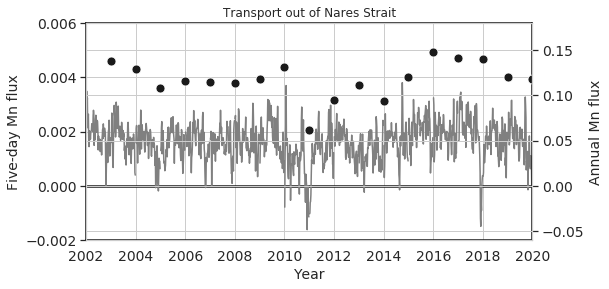

In [12]:
st = sns.axes_style("whitegrid")
    
with st:
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax2 = ax.twinx()
    
    sns.lineplot([dt.datetime(2002,1,1), dt.datetime(2020,1,1)], [0,0], linewidth=2.5, color='k', ax=ax)
    
    sum_Nout_ref = [];
    for year in range(2002, 2019+1):
        # Calculate volume and Mn fluxes
        Nout_ref, Nout_riv, Nout_con, Nout_nosed = calculate_fluxes(year)
            
        dates_year    = file_dates(year)    
            
        # Plot lines:
        sns.lineplot(dates_year, Nout_ref, linewidth=1.5, color='gray', ax=ax)
        
        sum_Nout_ref.append(np.sum(Nout_ref))
    
    annual_dates = [dt.datetime(year,12,31) for year in range(2002,2020)]
    sns.scatterplot(annual_dates, sum_Nout_ref, color='k', s=80, ax=ax2)
    
    # Figure settings:
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.002, 0.006))
    ax2.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.06, 0.18))
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Five-day Mn flux', fontsize=14)
    ax2.set_ylabel('Annual Mn flux', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title('Transport out of Nares Strait')
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');